In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

# Things to  keep in mind :-
1. Folder name of data should be dataset_64 , having 1 sub folder of each type which contains the images 
2. Make sure no preexisting folder named "data" exist in that location 
3. Match size is just 4 - need to increase when more data 
4. Outputs shown are old outputs so nned to run the notebook in chitra lapi too get normal outputs. 
5. Testing data need to be first inputted from UI then transformmed into either 64*64 / 128*128 and then pasted in test folder that script will create. 


In [3]:
listofwaste = os.listdir(os.path.join(os.getcwd(),"dataset_128"))
print(listofwaste)
print(os.getcwd())

['biodegradable', 'non biodegradable']
C:\Users\chitr\Desktop\project-final\model-3


In [4]:
newfolders = ['train','valid']
waste_types = listofwaste.copy()

## create destination folders for data subset and waste type
for nfolder in newfolders:
    for waste_type in waste_types:
        folder = os.path.join('data',nfolder,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

In [5]:
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))

In [6]:
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.copy(file,destination_folder)

In [7]:
## Moving data to test and validation folderz
for waste_type in waste_types:
    src_folder = os.path.join(os.getcwd(),'dataset_128',waste_type)
    filesinsrcfolder = os.listdir(src_folder)
    size = len(filesinsrcfolder)
    indexlist=[]
    for i in range(0,size):
        indexlist.append(i)
    random.seed(5)
    train_idx = random.sample(indexlist,int(0.7*size))
    valid_idx = list(set(indexlist)-set(train_idx))
    train_names = []
    valid_names = []
    for i in train_idx:
        train_names.append(filesinsrcfolder[i])
    for i in valid_idx:
        valid_names.append(filesinsrcfolder[i])
    train_source_files = [os.path.join(src_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    valid_source_files = [os.path.join(src_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    

C:\Users\chitr\Desktop\project-final


In [8]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Users/chitr/Desktop/project-final/model-3/data')

In [9]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,ds_tfms=tfms,bs=16)

In [10]:
data

ImageDataBunch;

Train: LabelList (2048 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
biodegradable,biodegradable,biodegradable,biodegradable,biodegradable
Path: C:\Users\chitr\Desktop\project-final\model-3\data;

Valid: LabelList (877 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
biodegradable,biodegradable,biodegradable,biodegradable,biodegradable
Path: C:\Users\chitr\Desktop\project-final\model-3\data;

Test: None

In [11]:
data.classes

['biodegradable', 'non biodegradable']

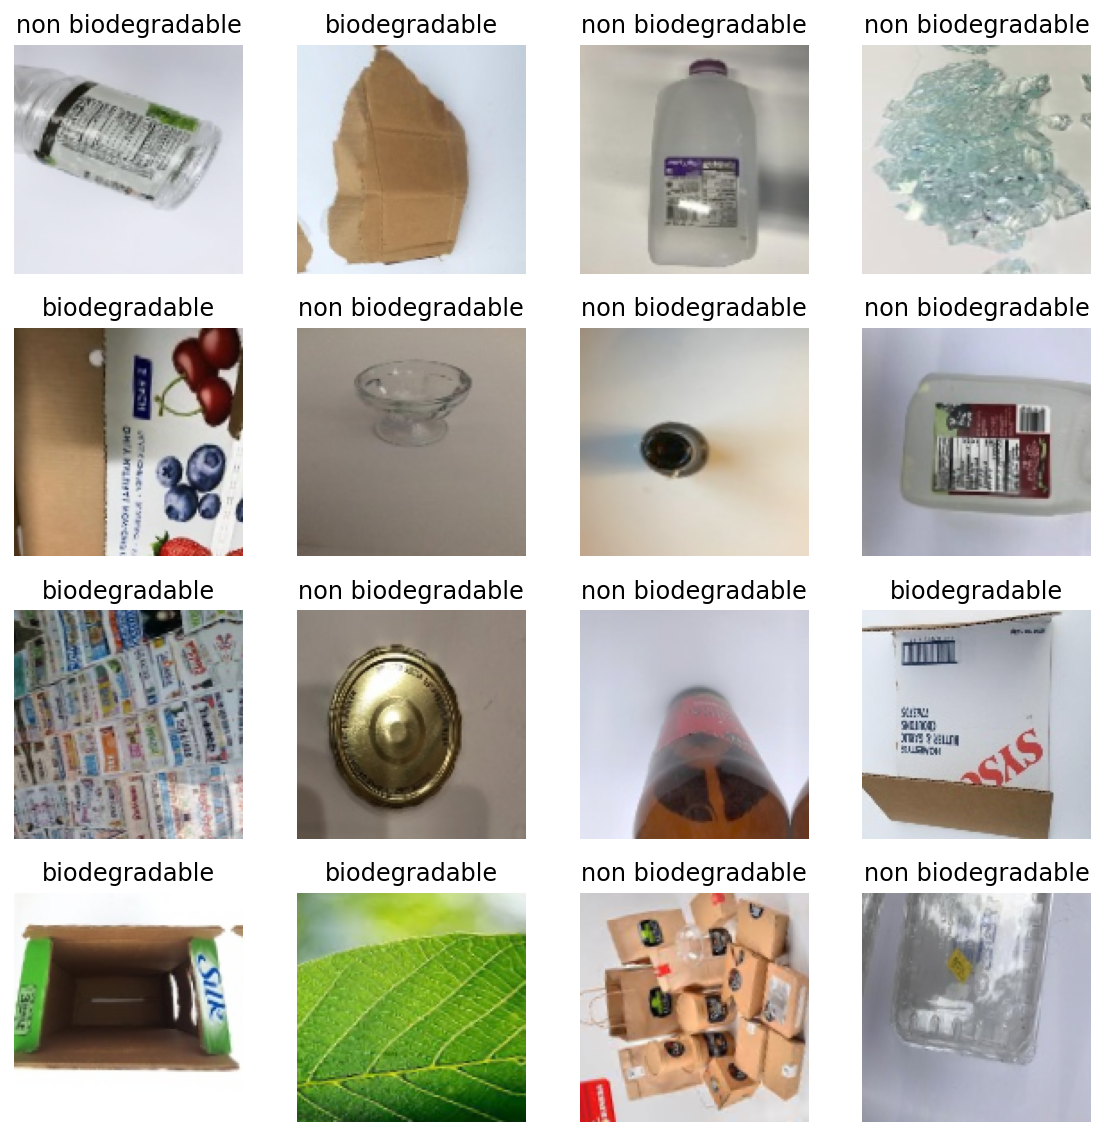

In [12]:
data.show_batch(rows = 4,figsize = (8,8))

In [13]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

c:\users\chitr\appdata\local\programs\python\python37\lib\site-packages\fastai\vision\learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


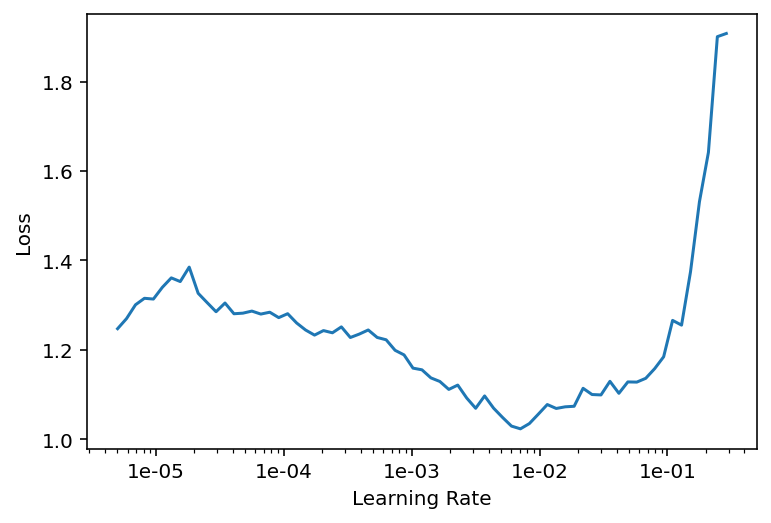

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(10,max_lr=3.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.643156,0.327526,0.124287,08:01
1,0.512411,0.261195,0.087799,08:14
2,0.434168,0.292800,0.117446,08:23
3,0.336641,0.214236,0.083238,07:04
4,0.328208,0.224546,0.088940,07:02
5,0.292002,0.170757,0.053592,06:56
6,0.258069,0.146538,0.055872,07:05
7,0.206562,0.132689,0.050171,06:35
8,0.180382,0.137168,0.047891,04:49
9,0.199128,0.134085,0.049031,04:49


In [18]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

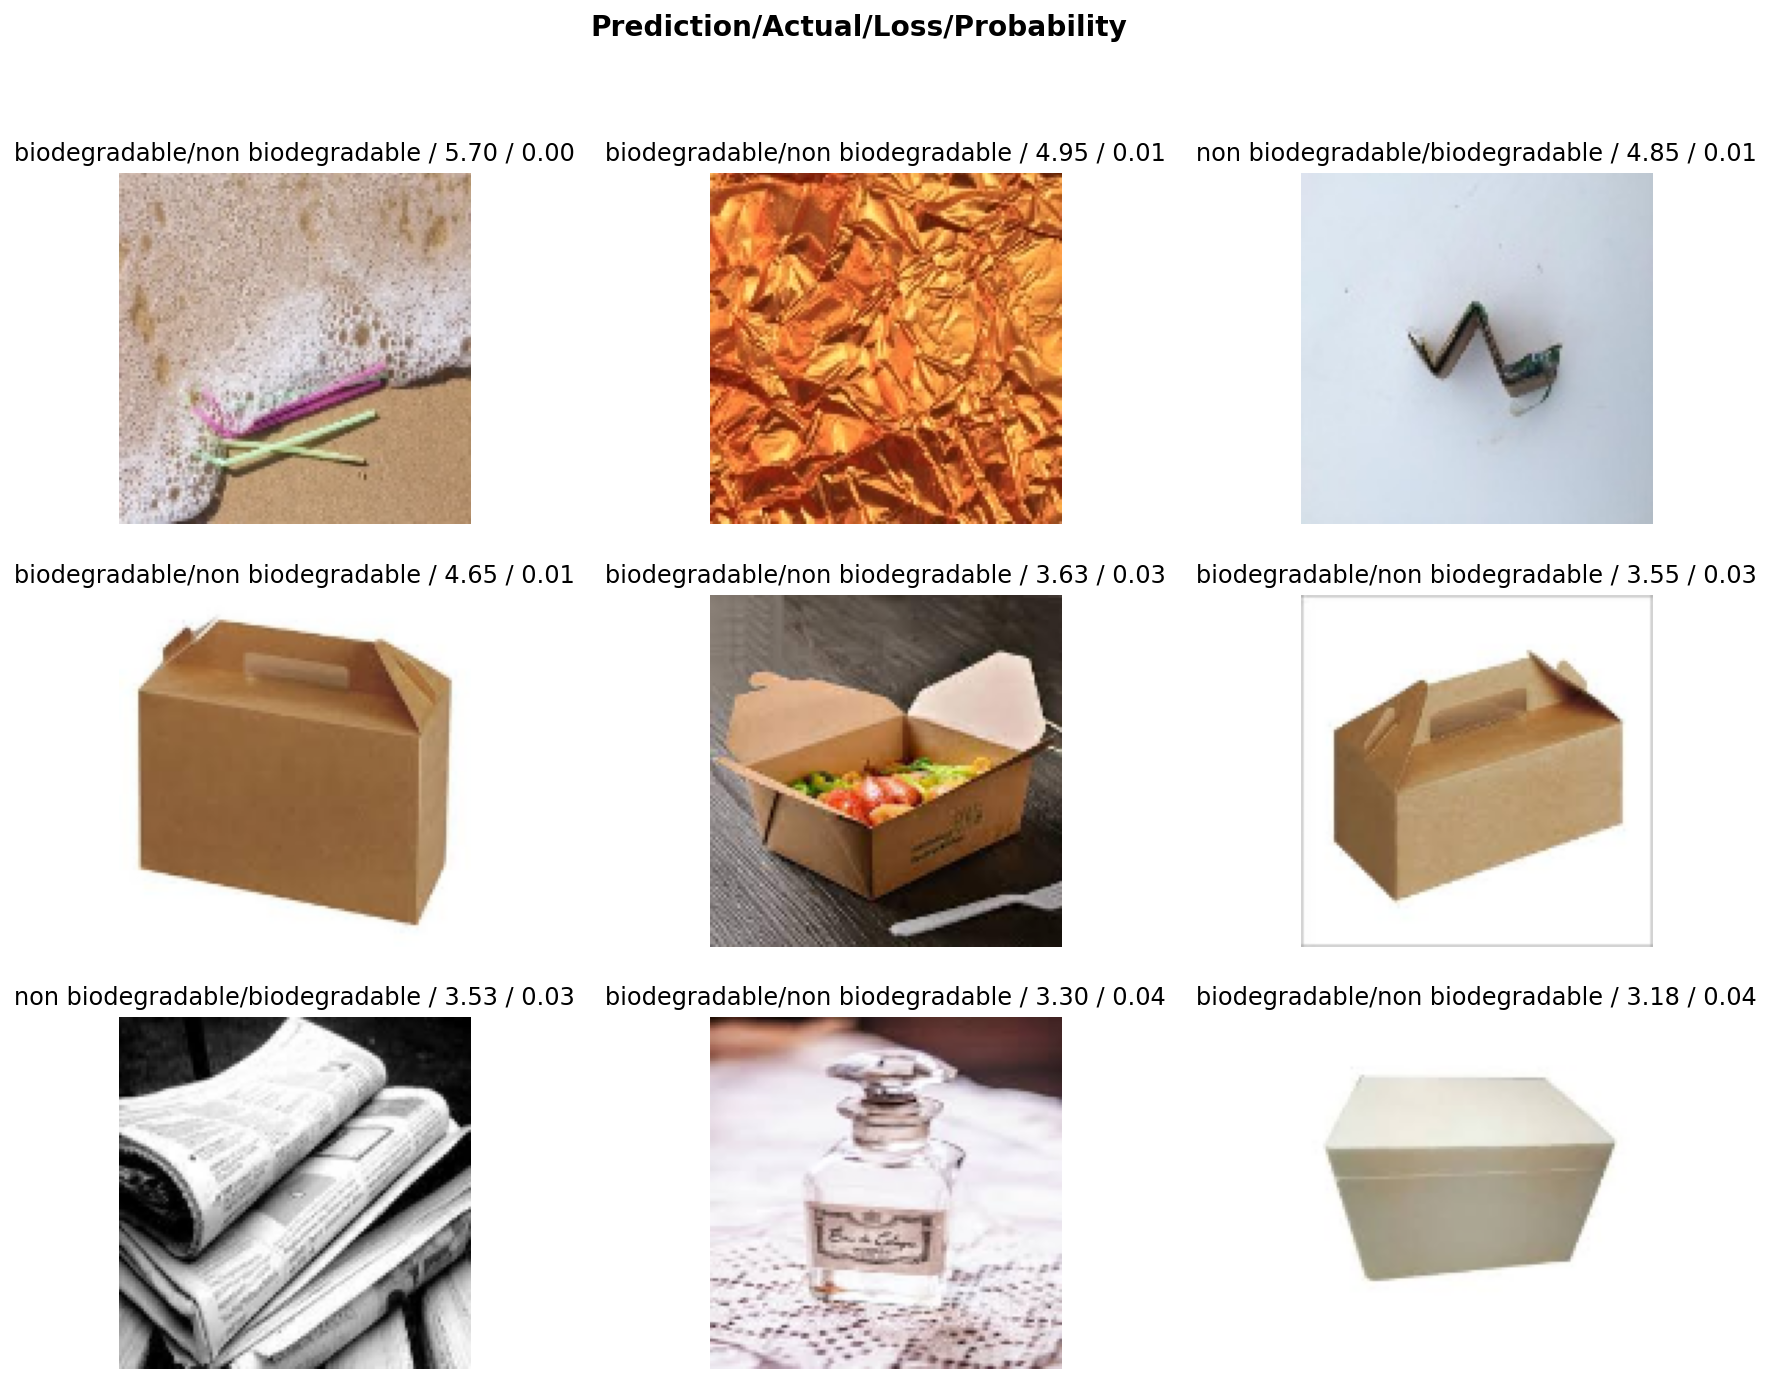

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

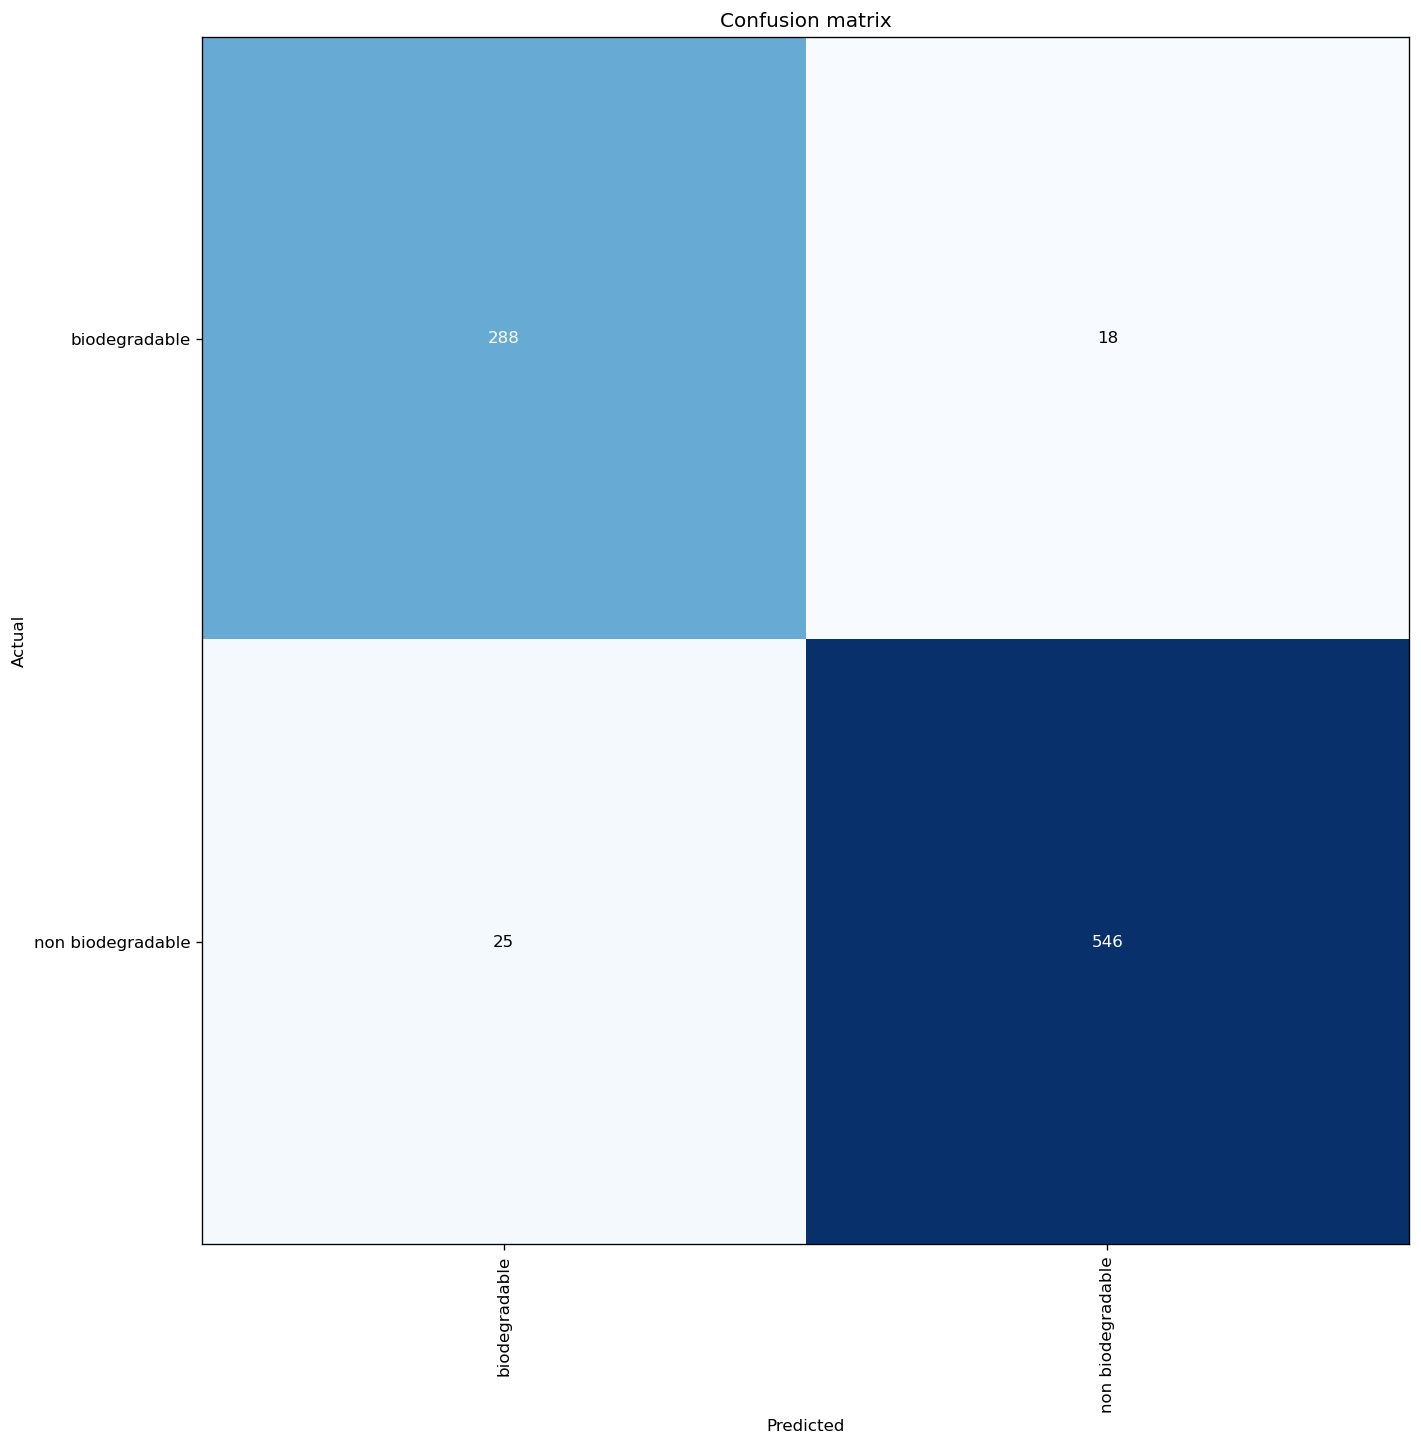

In [20]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('non biodegradable', 'biodegradable', 25),
 ('biodegradable', 'non biodegradable', 18)]

In [26]:
print(((877-43)*100)/877)

95.09692132269099
